# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo



# 1. Dataset Overview and PreProcessing



### Problem Statement:
The task is to predict the probability that an online transaction is fraudulent using identity and transaction data.

### Dataset Description:
- **Target variable:** `isFraud` (1 = fraud, 0 = not fraud)
- **Files:** `train_transaction.csv`, `train_identity.csv` (joined on `TransactionID`)
- **Features:**  
  - *Transaction Data:* ProductCD, card1–card6, addr1, addr2, M1–M9  
  - *Identity Data:* DeviceType, DeviceInfo, id_12–id_38  
- The feature `TransactionDT` is a relative timestamp.


## 2. Defining all the Imports and necessary dependencies

In [88]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from joblib import dump
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping

## Data PreProcessing

### 1. Loading and Merge Data

In [68]:
# Load datasets
train_transaction = pd.read_csv('data/train_transaction.csv')
train_identity = pd.read_csv('data/train_identity.csv')
test_transaction = pd.read_csv('data/test_transaction.csv')
test_identity = pd.read_csv('data/test_identity.csv')

In [69]:
# Merge on TransactionID
train_df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test_df = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

# Separate target
y = train_df['isFraud']
X = train_df.drop(columns=['isFraud', 'TransactionID'])

### 2. Outlier Clipping

In [70]:
class OutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor

    def fit(self, X, y=None):
        # Convert to DataFrame if not already, so quantile works
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        Q1 = X.quantile(0.25)
        Q3 = X.quantile(0.75)
        self.lower = Q1 - self.factor * (Q3 - Q1)
        self.upper = Q3 + self.factor * (Q3 - Q1)
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        # Clip values
        X_clipped = X.clip(lower=self.lower, upper=self.upper, axis=1)
        return X_clipped.values  # return NumPy array to keep pipeline consistent

### 3. Feature Grouping

In [71]:
# Identify features by type
categorical = X.select_dtypes(include='object').columns.tolist()
numerical = X.select_dtypes(include=[np.number]).columns.tolist()

# Further split categorical
low_card = [col for col in categorical if X[col].nunique() < 10]
high_card = list(set(categorical) - set(low_card))

### 4. PreProcessing Pipeline

In [ ]:
# Pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('clipper', OutlierClipper()),
    ('scaler', StandardScaler())
])

low_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # For categorical, use most_frequent
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

high_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder())
])

# Full transformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical),
    ('low_cat', low_cat_pipeline, low_card),
    ('high_cat', high_cat_pipeline, high_card)
])

### 5. Data Splitting

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Apply variance thresholding
selector = VarianceThreshold(threshold=0.0001)
X_train_processed = selector.fit_transform(X_train_processed)
X_val_processed = selector.transform(X_val_processed)
X_test_processed = selector.transform(X_test_processed)

# SECTION 1: Model Architecture



```
TODO: Insert an image with the Model architecture here.Replace the image Below
```
> <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*v1ohAG82xmU6WGsG2hoE8g.png" alt="?" style="width:25px"/>




## Task: Define a function that creates models without specified Optimization techniques


### Model 1:
A Logistic Regression model for classification, setting a regularization parameter (C=0.5) and increasing maximum iterations. It then fits the model to the training data and makes predictions on the validation set.

In [ ]:
log_model = LogisticRegression(C=0.5, max_iter=1000)
log_model.fit(X_train_processed, y_train)
y_pred_log = log_model.predict(X_val_processed)

dump(log_model, 'saved_models/logistic_model.joblib')

['saved_models/logistic_model.joblib']

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

### Model 2:
A simple neural network with two hidden layers (64 and 32 neurons) for binary classification. It's then compiled using the Adam

In [ ]:
model_2 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_processed.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_2 = model_2.fit(X_train_processed, y_train, epochs=100, batch_size=32,
                        validation_data=(X_val_processed, y_val), verbose=1)

save_model(model_2, 'saved_models/nn_instance_2.h5')

/Users/irakizagaius/Downloads/FraudDetection/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
14764/14764 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - accuracy: 0.9704 - loss: 0.1080 - val_accuracy: 0.9742 - val_loss: 0.0922
Epoch 2/10
14764/14764 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.9745 - loss: 0.0921 - val_accuracy: 0.9748 - val_loss: 0.0901
Epoch 3/10
14764/14764 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.9758 - loss: 0.0877 - val_accuracy: 0.9756 - val_loss: 0.0878
Epoch 4/10
14764/14764 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.9763 - loss: 0.0850 - val_accuracy: 0.9762 - val_loss: 0.0855
Epoch 5/10
14764/14764 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.9770 - loss: 0.0821 - val_accuracy: 0.9767 - val_loss: 0.0852
Epoch 6/10
14764/14764 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.9772 - loss: 0.0808 - val_accuracy: 0.9763 - val_loss: 0.0844
Epoch 7/10
14764/14764 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.9778 - loss: 0.0787 - val_accuracy: 0.9774 - val_loss: 0.0827
Epoch 8/10
14764/14764 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 685us/step


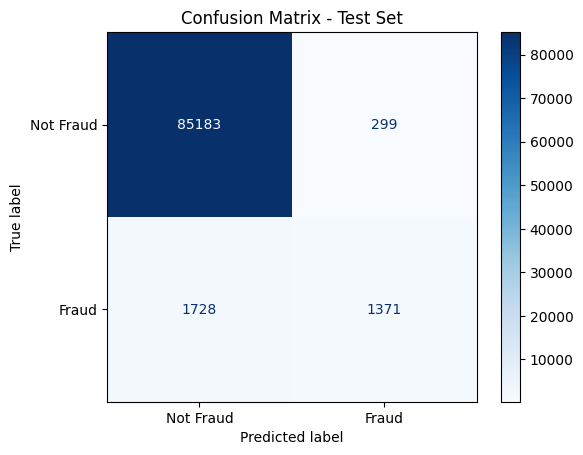

=== Classification Report ===
              precision    recall  f1-score   support

   Not Fraud       0.98      1.00      0.99     85482
       Fraud       0.82      0.44      0.57      3099

    accuracy                           0.98     88581
   macro avg       0.90      0.72      0.78     88581
weighted avg       0.97      0.98      0.97     88581

True Negatives (TN): 85183
False Positives (FP): 299
False Negatives (FN): 1728
True Positives (TP): 1371


In [90]:
# Predict probabilities and convert to binary labels
y_test_pred_prob = model_2.predict(X_test_processed)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)
y_test_true = y_test.values.reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Detailed classification report
report = classification_report(y_test_true, y_test_pred, target_names=["Not Fraud", "Fraud"])
print("=== Classification Report ===")
print(report)
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


### Model 3: 
 A neural network with two hidden layers (128 and 64 neurons) including L2 regularization on the first layer for binary classification. It's compiled with an Adam optimizer and trained for up to 50 epochs using early stopping to capture the best weights.

In [77]:
model_3 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_processed.shape[1],), kernel_regularizer=l2(0.001)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_3.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_2 = model_3.fit(X_train_processed, y_train, epochs=50, batch_size=100,
                        validation_data=(X_val_processed, y_val),
                        callbacks=[early_stopping], verbose=1)

save_model(model_3, 'saved_models/nn_instance_3.h5')


Epoch 1/50
4725/4725 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9697 - loss: 0.1388 - val_accuracy: 0.9711 - val_loss: 0.1073
Epoch 2/50
4725/4725 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9724 - loss: 0.1036 - val_accuracy: 0.9728 - val_loss: 0.1020
Epoch 3/50
4725/4725 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9728 - loss: 0.1012 - val_accuracy: 0.9735 - val_loss: 0.0985
Epoch 4/50
4725/4725 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9731 - loss: 0.1008 - val_accuracy: 0.9730 - val_loss: 0.0997
Epoch 5/50
4725/4725 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9736 - loss: 0.0987 - val_accuracy: 0.9735 - val_loss: 0.1016
Epoch 6/50
4725/4725 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9738 - loss: 0.0980 - val_accuracy: 0.9736 - val_loss: 0.0988
Epoch 7/50
4725/4725 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9735 - loss: 0.0997 - val_accuracy: 0.9732 - val_loss: 0.1014
Epoch 8/50
4725/4725 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9737 - loss: 0.0987 - 

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 759us/step


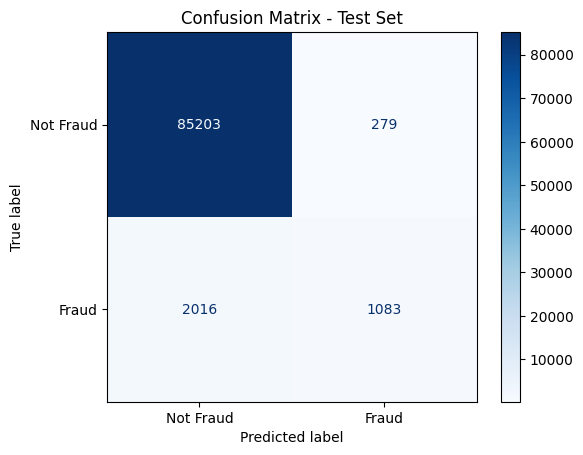

=== Classification Report ===
              precision    recall  f1-score   support

   Not Fraud       0.98      1.00      0.99     85482
       Fraud       0.80      0.35      0.49      3099

    accuracy                           0.97     88581
   macro avg       0.89      0.67      0.74     88581
weighted avg       0.97      0.97      0.97     88581

True Negatives (TN): 85203
False Positives (FP): 279
False Negatives (FN): 2016
True Positives (TP): 1083


In [91]:
# Predict probabilities and convert to binary labels
y_test_pred_prob = model_3.predict(X_test_processed)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)
y_test_true = y_test.values.reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Detailed classification report
report = classification_report(y_test_true, y_test_pred, target_names=["Not Fraud", "Fraud"])
print("=== Classification Report ===")
print(report)
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


### Model 4:
  A neural network featuring L1 regularization and Dropout layers across its hidden architecture for binary classification. It's compiled with RMSprop and trained for 50 epochs, utilizing early stopping with a larger batch size.

In [78]:
model_4 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_processed.shape[1],), kernel_regularizer=l1(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_4.compile(optimizer=RMSprop(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_4 = model_4.fit(X_train_processed, y_train, epochs=50, batch_size=64,
                        validation_data=(X_val_processed, y_val),
                        callbacks=[early_stopping], verbose=1)

save_model(model_4, 'saved_models/nn_instance_4.h5')


Epoch 1/50
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9682 - loss: 0.2894 - val_accuracy: 0.9715 - val_loss: 0.1236
Epoch 2/50
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9702 - loss: 0.1300 - val_accuracy: 0.9718 - val_loss: 0.1215
Epoch 3/50
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9703 - loss: 0.1292 - val_accuracy: 0.9710 - val_loss: 0.1239
Epoch 4/50
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9703 - loss: 0.1282 - val_accuracy: 0.9707 - val_loss: 0.1254
Epoch 5/50
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9704 - loss: 0.1273 - val_accuracy: 0.9721 - val_loss: 0.1208
Epoch 6/50
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9703 - loss: 0.1285 - val_accuracy: 0.9720 - val_loss: 0.1220
Epoch 7/50
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9709 - loss: 0.1268 - val_accuracy: 0.9717 - val_loss: 0.1227
Epoch 8/50
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9706 - loss: 0

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 673us/step


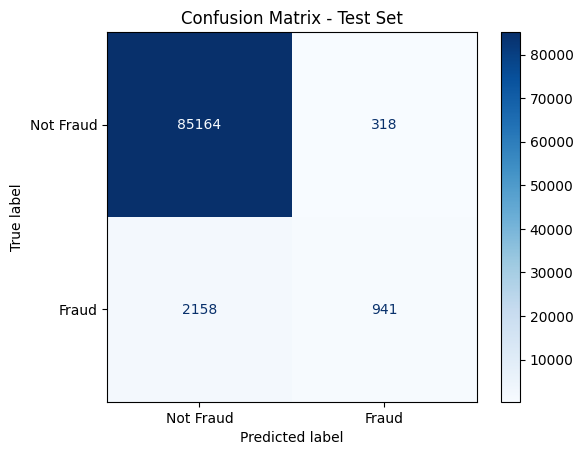

=== Classification Report ===
              precision    recall  f1-score   support

   Not Fraud       0.98      1.00      0.99     85482
       Fraud       0.75      0.30      0.43      3099

    accuracy                           0.97     88581
   macro avg       0.86      0.65      0.71     88581
weighted avg       0.97      0.97      0.97     88581

True Negatives (TN): 85164
False Positives (FP): 318
False Negatives (FN): 2158
True Positives (TP): 941


In [92]:
# Predict probabilities and convert to binary labels
y_test_pred_prob = model_4.predict(X_test_processed)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)
y_test_true = y_test.values.reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Detailed classification report
report = classification_report(y_test_true, y_test_pred, target_names=["Not Fraud", "Fraud"])
print("=== Classification Report ===")
print(report)
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


### Model 5:
A deep neural network with three hidden layers (256, 128, 64 neurons), applying L2 regularization on the first layer for binary classification. It's compiled using the SGD optimizer and trained for 30 epochs with a batch size of 64. The trained model is then saved to a file.

In [79]:
model_5 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_processed.shape[1],), kernel_regularizer=l2(0.0001)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_5.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

history_5 = model_5.fit(X_train_processed, y_train, epochs=30, batch_size=64,
                        validation_data=(X_val_processed, y_val), verbose=1)

save_model(model_5, 'saved_models/nn_instance_5.h5')


Epoch 1/30
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9659 - loss: 0.1445 - val_accuracy: 0.9720 - val_loss: 0.1176
Epoch 2/30
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9719 - loss: 0.1167 - val_accuracy: 0.9727 - val_loss: 0.1133
Epoch 3/30
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9727 - loss: 0.1119 - val_accuracy: 0.9734 - val_loss: 0.1105
Epoch 4/30
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9731 - loss: 0.1100 - val_accuracy: 0.9737 - val_loss: 0.1078
Epoch 5/30
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9733 - loss: 0.1084 - val_accuracy: 0.9741 - val_loss: 0.1058
Epoch 6/30
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9742 - loss: 0.1053 - val_accuracy: 0.9741 - val_loss: 0.1054
Epoch 7/30
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9746 - loss: 0.1041 - val_accuracy: 0.9746 - val_loss: 0.1034
Epoch 8/30
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9752 - loss: 0

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 851us/step


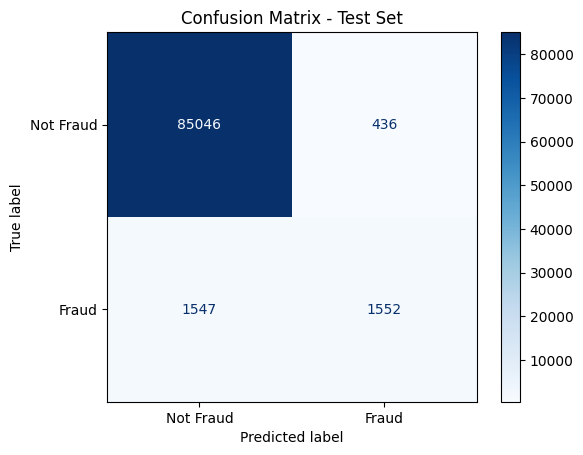

=== Classification Report ===
              precision    recall  f1-score   support

   Not Fraud       0.98      0.99      0.99     85482
       Fraud       0.78      0.50      0.61      3099

    accuracy                           0.98     88581
   macro avg       0.88      0.75      0.80     88581
weighted avg       0.98      0.98      0.98     88581

True Negatives (TN): 85046
False Positives (FP): 436
False Negatives (FN): 1547
True Positives (TP): 1552


In [93]:
# Predict probabilities and convert to binary labels
y_test_pred_prob = model_5.predict(X_test_processed)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)
y_test_true = y_test.values.reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Detailed classification report
report = classification_report(y_test_true, y_test_pred, target_names=["Not Fraud", "Fraud"])
print("=== Classification Report ===")
print(report)
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


# Task: Print out the Final Model Accuracy and plot the Loss curve

In [84]:
def evaluate_model(y_true, y_pred_prob):
    y_pred = (y_pred_prob > 0.5).astype(int)
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred)
    }

# Get validation predictions
val_preds = {
    'Instance 1': model_2.predict(X_val_processed),
    'Instance 2': model_3.predict(X_val_processed),
    'Instance 3': model_4.predict(X_val_processed),
    'Instance 4': model_5.predict(X_val_processed),
    'Instance 5': log_model.predict_proba(X_val_processed)[:, 1],
}

# Get test predictions
test_preds = {
    'Instance 1': model_2.predict(X_test_processed),
    'Instance 2': model_3.predict(X_test_processed),
    'Instance 3': model_4.predict(X_test_processed),
    'Instance 4': model_5.predict(X_test_processed),
    'Instance 5': log_model.predict_proba(X_test_processed)[:, 1],
}

# Evaluate
val_results = {k: evaluate_model(y_val, v) for k, v in val_preds.items()}
test_results = {k: evaluate_model(y_test, v) for k, v in test_preds.items()}

# Function to print results
def print_results(title, results):
    print(f"\n=== {title} ===")
    print(f"{'Instance':<12} {'Accuracy':<10} {'F1 Score':<10} {'Precision':<10} {'Recall':<10}")
    print("=" * 60)
    for instance, metrics in results.items():
        print(f"{instance:<12} "
              f"{metrics['accuracy']:<10.4f} "
              f"{metrics['f1']:<10.4f} "
              f"{metrics['precision']:<10.4f} "
              f"{metrics['recall']:<10.4f}")

# Print both results
print_results("Validation Set Evaluation", val_results)
print_results("Test Set Evaluation", test_results)

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 636us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 601us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 639us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 684us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 610us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 616us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 622us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 729us/step

=== Validation Set Evaluation ===
Instance     Accuracy   F1 Score   Precision  Recall    
Instance 1   0.9794     0.6185     0.8778     0.4774    
Instance 2   0.9747     0.4971     0.8159     0.3574    
Instance 3   0.9722     0.4293     0.7605     0.2990    
Instance 4   0.9809     0.6713     0.8445     0.5571    
Instance 5   0.9713     0.3650     0.8035     0.2361    

=== Test Set Evaluation ===
Instance     Accuracy   F1 Score   Precision  Recall    
Instance 1   0.9771     0.5750     0.8210     0.4424    
Instance 2   0.9741     0.4855     0.7952     0.3495    
Instance 3   0.9720     0.4318     0.7474     0.3036    
Instan

# SECTION 3: Predictions on The Best Model
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [ ]:
def make_predictions(model_path, X):

    # Load the model
    model = load_model(None)
    # Make predictions
    predictions = None
    # Convert probabilities to binary labels (0 or 1)

    return predictions

#Modify the code appropriately

In [ ]:
model_path = None
make_predictions(None)